### Initialization
Installing requirements, auto reload changing to code, imports and some configurations

In [1]:
%pip install -r ../requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import dice_ml

import multiprocessing

from copy import deepcopy

import time

import json

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# disable tqdm progress bar by default
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

### Define research parameters

In [5]:
regression_task = False
continuous_features = ['Age', 'Credit amount', 'Duration']
metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
test_size_proportion = 0.2#0.33
augment_sample = 0.5

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random', 'kw_args': {'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 7, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2,
                                         'total_CFs': 10}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [6]:
raw_data = pd.read_csv(r"../datasets/german_credit.csv", index_col=0)
df = utils.preprocess_german(raw_data)
target = 'Risk'

#### split data

In [7]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [8]:
display(y_train.value_counts())

1    559
0    241
Name: Risk, dtype: int64

In [9]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [10]:
print(f'whole adult dataset scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
whole_dataset_result_df

whole adult dataset scores:


whole                                       
           f1 accuracy precision    recall   roc_auc
lg   0.832258    0.740  0.783951  0.929078  0.752374
rf   0.839879    0.735  0.731579  1.000000  0.789278
xgb  0.833333    0.750  0.786164  0.921986  0.801238

In [11]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [12]:
from data_augmentaion.data_augmentator import DataAugmentor 

In [13]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])


    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 7.610408782958984 seconds for settings 0
2 / 4, {'method': 'smote'} 7.669332504272461 seconds for settings 1
3 / 4, {'method': 'cf_random', 'kw_args': {'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.842809364548495}}
0/318
50/318
100/318
150/318
200/318
250/318
300/318
model for cf f1 score: {'cf': {'f1': 0.842809364548495}}
0/400
50/400
100/400
150/400
200/400
250/400
300/400
350/400
73.27975654602051 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 7, 'diversity_weight': 0.2, 'sparsity_weight': 0.2, 'total_CFs': 10}} model for cf f1 score: {'cf': {'f1': 0.842809364548495}}
0/318
50/318
model for cf f1 score: {'cf': {'f1': 0.842809364548495}}
0/400
50/400
100/400
150/400
224.75052428245544 seconds for settings 3

Total time: 313.3100221157074


# summary

In [14]:
full_results_df

whole                                        random balanced           \
           f1 accuracy precision    recall   roc_auc              f1 accuracy   
lg   0.832258    0.740  0.783951  0.929078  0.752374        0.748031    0.680   
rf   0.839879    0.735  0.731579  1.000000  0.789278        0.748971    0.695   
xgb  0.833333    0.750  0.786164  0.921986  0.801238        0.802974    0.735   

                                     random                               \
    precision    recall   roc_auc        f1 accuracy precision    recall   
lg   0.840708  0.687943  0.759106  0.844156    0.755  0.783951  0.921986   
rf   0.894231  0.652482  0.807669  0.848297    0.755  0.752747  0.985816   
xgb  0.843750  0.758865  0.798894  0.836120    0.755  0.791139  0.900709   

              smote balanced                                            smote  \
      roc_auc             f1 accuracy precision    recall   roc_auc        f1   
lg   0.758264       0.767442    0.700  0.846154  0.702128  0.785792  0.767442   
rf   0.785070       0.774704    0.715  0.872727  0.695035  0.824138  0.774704   
xgb  0.788196       0.802920    0.730  0.827068  0.780142  0.788436  0.802920   

                                           cf_random balanced           \
    accuracy precision    recall   roc_auc                 f1 accuracy   
lg     0.700  0.846154  0.702128  0.785792           0.798561     0.72   
rf     0.715  0.872727  0.695035  0.824138           0.835714     0.77   
xgb    0.730  0.827068  0.780142  0.788436           0.836879     0.76   

                                  cf_random                               \
    precision    recall   roc_auc        f1 accuracy precision    recall   
lg   0.810219  0.787234  0.745522  0.787004     0.70  0.800000  0.773050   
rf   0.841727  0.822695  0.770886  0.804511     0.74  0.856000  0.737589   
xgb  0.829787  0.836879  0.813319  0.802920     0.73  0.827068  0.780142   

              cf_genetic balanced                                         \
      roc_auc                  f1 accuracy precision    recall   roc_auc   
lg   0.743719            0.745247    0.670  0.815126  0.695035  0.742277   
rf   0.774372            0.766129    0.710  0.887850  0.673759  0.780983   
xgb  0.795408            0.805861    0.735  0.833333  0.780142  0.783868   

    cf_genetic                                         
            f1 accuracy precision    recall   roc_auc  
lg    0.740157    0.670  0.844037  0.666667  0.749008  
rf    0.760331    0.710  0.910891  0.652482  0.790600  
xgb   0.814815    0.745  0.857143  0.780142  0.781825

In [15]:
print('best methods:')
display(utils.get_best_methods(full_results_df))

best methods:


,f1,accuracy,precision,recall,roc_auc
lg,random,random,smote balanced,whole,smote balanced
rf,random,cf_random balanced,cf_genetic,whole,smote balanced
xgb,cf_random balanced,cf_random balanced,cf_genetic,whole,cf_random balanced
overall,random,cf_random balanced,cf_genetic,whole,smote balanced


In [19]:
utils.save_results_as_latex_tables(full_results_df, task_name="german")

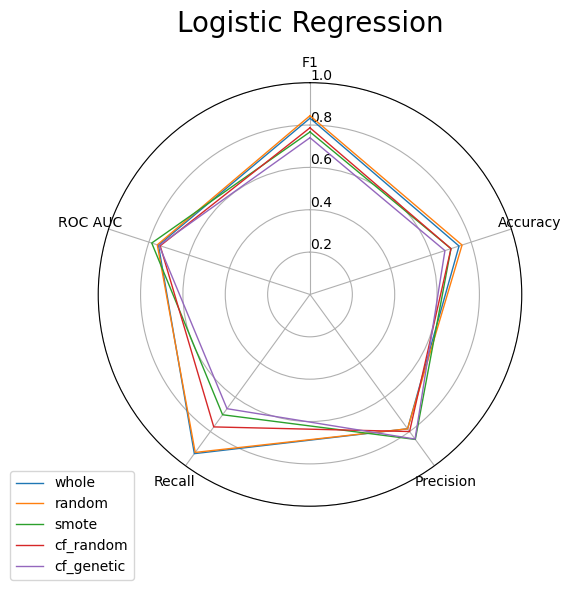

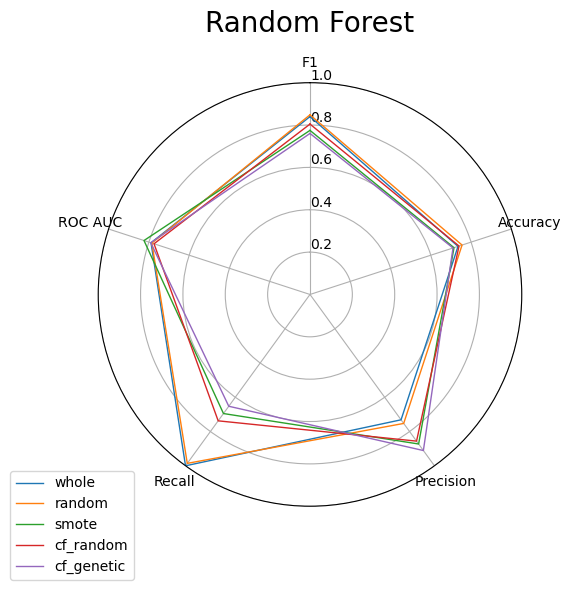

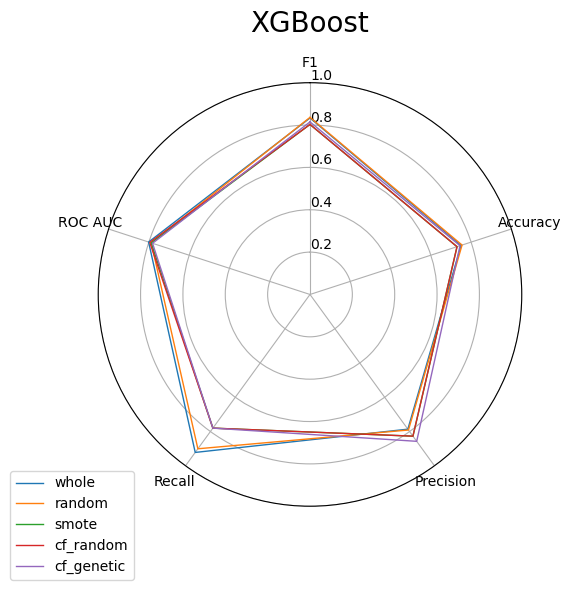

In [17]:
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = {'f1': 'F1',
                'accuracy': 'Accuracy',
                'precision': 'Precision',
                'recall': 'Recall',
                'roc_auc': 'ROC AUC'}
utils.spider_plot(full_results_df, 'lg', wanted_cols, metric_names, 'Logistic Regression', save_task_name='german')
utils.spider_plot(full_results_df, 'rf', wanted_cols, metric_names, 'Random Forest', save_task_name='german')
utils.spider_plot(full_results_df, 'xgb', wanted_cols, metric_names, 'XGBoost', save_task_name='german')

In [18]:
full_results_df.to_csv(rf'../log/experiment_german.csv')